In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from livelossplot import PlotLosses
from tqdm import tnrange, tqdm_notebook
from keras import backend as K
from keras.models import Model
from keras.layers import Input, LSTM, Dense, BatchNormalization, Dropout, LeakyReLU, Lambda
from keras.layers.wrappers import TimeDistributed
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from IPython import display as dp
import os
import pickle

sns.set_style('whitegrid')
sns.despine()

dp.set_matplotlib_formats('retina')

%matplotlib inline

/Users/nickstulov/.virtualenvs/venv3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


A stateful LSTM, reads `horizon` time steps, predicts next one for each, outputs all answers.

In [2]:
class DataLoader():
    """
    Batches generator.
    
    Takes a directory `path`, sequentially reads `batch_size` files, then
        sequentially reads `horizon` timestamps from each file.
        
    Args:
        path (str): Path to collection.
        batch_size (int): Number of documents per batch.
        horizon (int): Number of timestamps per batch.
        dimension (int): Series vector length.
    """
    def __init__(self, path, batch_size, horizon, dimension):
        self._batch_size = batch_size
        self._horizon = horizon
        self._dimension = dimension
        self._collection = [os.path.join(path, x) for x in os.listdir(path) if x != '.DS_Store']
        self._collection_size = len(self._collection)
        self._num_batches = self._collection_size // self._batch_size + 1
        self._cursor_collection = 0
        self._cursor_file = 0
        with open('sc.pickle', 'rb') as f:
            self._sc = pickle.load(f)
        self._read_next_files()
        self._file_size = 151
        self._last_batch = False
        
    def _read_next_files(self):
        """
        Reads the collection by chunks to save memory.
        """
        files_to_read = self._collection[self._cursor_collection : self._cursor_collection + self._batch_size]
        self._cursor_collection += self._batch_size
        if self._cursor_collection > self._collection_size:
            diff = self._cursor_collection % self._collection_size
            self._cursor_collection = diff
            files_to_read.extend(self._collection[0 : diff])
        self._files = [self._sc.transform(pd.read_csv(fpath).drop(['t'], axis=1).values) for fpath in files_to_read]
        
    def _read_from_files(self):
        """
        Reads one timestamp for multiple series.
        
        Returns:
            batch (numpy array): Array of shape (batch_size, 1, dimension).
            reset (bool): Whether states should be reset.
        """
        batch = np.zeros((self._batch_size, self._dimension))
        for i, doc in enumerate(self._files):
            batch[i] = doc[self._cursor_file]
        self._cursor_file += 1
        if self._cursor_file == self._file_size:
            self._cursor_file = self._cursor_file % self._file_size
            self._read_next_files()
            return batch, True
        else:
            return batch, False
        
    def next(self):
        """
        Reads multiple timestamps for multiple series, i.e. complete batch.
        """
        batch = np.zeros((self._batch_size, self._horizon, self._dimension))
        for i in range(self._horizon):
            b, reset = self._read_from_files()
            batch[:, i, :] = b
            if reset:
                self._last_batch = True
                return batch, True
        self._last_batch = False
        return batch, False

In [3]:
class DataLoaderOverlap():
    """
    Batches generator.
    
    Takes a directory `path`, sequentially reads `batch_size` files, then
        sequentially reads `horizon` timestamps from each file.
        
    Args:
        path (str): Path to collection.
        batch_size (int): Number of documents per batch.
        horizon (int): Number of timestamps per batch.
        dimension (int): Series vector length.
    """
    def __init__(self, path, batch_size, horizon, dimension):
        self._batch_size = batch_size
        self._horizon = horizon
        self._dimension = dimension
        with open('sc.pickle', 'rb') as f:
            self._sc = pickle.load(f)
        self._collection = [self._sc.transform(pd.read_csv(fpath).drop(['t'], axis=1).values) \
                            for fpath in [os.path.join(path, x) for x in os.listdir(path) if x != '.DS_Store']]
        np.random.shuffle(self._collection)
        self._collection_size = len(self._collection)
        self._num_batches = self._collection_size // self._batch_size + 1
        self._cursor_collection = 0
        self._cursor_file = 0
        self._read_next_files()
        self._file_size = 151
        self._last_batch = self._read_from_files()
        
    def _read_next_files(self):
        """
        Reads the collection by chunks to save memory.
        """
        self._files = self._collection[self._cursor_collection : self._cursor_collection + self._batch_size]
        self._cursor_collection += self._batch_size
        if self._cursor_collection > self._collection_size:
            diff = self._cursor_collection % self._collection_size
            self._cursor_collection = diff
            self._files.extend(self._collection[0 : diff])
        
    def _read_from_files(self):
        """
        Reads one timestamp for multiple series.
        
        Returns:
            batch (numpy array): Array of shape (batch_size, 1, dimension).
            reset (bool): Whether states should be reset.
        """
        batch = np.zeros((self._batch_size, self._dimension))
        for i, doc in enumerate(self._files):
            batch[i] = doc[self._cursor_file]
        self._cursor_file += 1
        if self._cursor_file == self._file_size:
            self._cursor_file = self._cursor_file % self._file_size
            self._read_next_files()
            return batch, True
        else:
            return batch, False
        
    def next(self):
        """
        Reads multiple timestamps for multiple series, i.e. complete batch.
        """
        batch = np.zeros((self._batch_size, self._horizon + 1, self._dimension))
        if self._last_batch[1]:
             self._last_batch = self._read_from_files()
        batch[:, 0, :] = self._last_batch[0]
        for i in range(1, self._horizon + 1):
            b, reset = self._read_from_files()
            batch[:, i, :] = b
            if reset:
                self._last_batch = self._last_batch[0], True
                return batch, True
        self._last_batch = batch[:, -1, :], False
        return batch, False

In [4]:
epochs = 10000
batch_size = 50
num_hidden = 100
num_vars = 2
horizon = 30
dropout = 0.1

In [5]:
encoder_inputs = Input(batch_shape=(batch_size, None, num_vars))
encoder = LSTM(num_hidden, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(batch_shape=(batch_size, 1, num_vars))
decoder_lstm = LSTM(num_hidden, return_sequences=True, return_state=True)
decoder_dense = TimeDistributed(Dense(num_vars))

all_outputs = []
inputs = decoder_inputs
states = encoder_states
for _ in range(horizon):
    outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)
    outputs = decoder_dense(outputs)
    all_outputs.append(outputs)
    inputs = outputs
    states = [state_h, state_c]

decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [6]:
def nrmse(y_true, y_pred):
    return K.mean(K.sqrt(K.mean(K.sum((y_true - y_pred) ** 2, axis=2), axis=1)) \
                  / K.sqrt(K.mean(K.sum(y_true ** 2, axis=2), axis=1)))

In [7]:
model.compile(optimizer='adam', loss='mse', metrics=[nrmse])

In [8]:
dl = DataLoaderOverlap('data_sparse', batch_size, horizon, num_vars * 2)

In [117]:
rolling = []
for epoch in tnrange(int(1e5)):
    batch, reset = dl.next()
    hist_mse, hist_nrmse = model.train_on_batch([batch[:, :, :2],
                                                 batch[:, 0, 2:].reshape(batch_size, 1, num_vars)],
                                                batch[:, 1:, 2:])
    rolling.append(hist_nrmse)
    if epoch > 0 and epoch % 1000 == 0:
        files_valid = os.listdir('data_sparse_val')
        n_files = len(files_valid)
        errs = list()
        for i in range(batch_size, n_files // batch_size * batch_size + 1, batch_size):
            idx = range(i-batch_size, i)
            fnames = ['data_sparse_val/' + files_valid[i] for i in idx]
            vals = [pd.read_csv(fname).drop(['t'], axis=1).values for fname in fnames]
            true = [val[:, 2:] for val in vals]
            vals = [sc.transform(val) for val in vals]
            inputs = [val[:, :2] for val in vals]
            model.reset_states()
            predicted = np.zeros((batch_size, 151, 2))
            for j in range(horizon, 151 // horizon * horizon + 1, horizon):
                batch = np.zeros((batch_size, horizon, num_vars))
                for k in range(batch_size):
                    batch[k] = inputs[k][j-horizon:j]
                states_value = encoder_model.predict_on_batch(batch)

                target_seq = np.zeros((batch_size, 1, num_vars))
                for k in range(batch_size):
                    if j > horizon:
                        target_seq[k] = predicted[k][j-horizon-1]
                    else:
                        target_seq[k] = inputs[k][-1]

                for _ in range(30):
                    output_tokens, h, c = decoder_model.predict_on_batch([target_seq] + states_value)
                    for k in range(batch_size):
                        predicted[k][j-horizon:j] = output_tokens[k]
                        target_seq[k] = output_tokens[k]
                    states_value = [h, c]

            predicted = sc.inverse_transform(np.concatenate([inputs, predicted], axis=2))[:, :, 2:]

            err = [np.sqrt(np.mean(np.sum((t - p) ** 2, axis=1))) / np.sqrt(np.mean(np.sum(t ** 2, axis=1))) \
                   for t, p in zip(true, predicted)]
            errs.extend(err)
        
        print('Epoch', epoch, '— train RMSE — mean', np.mean(rolling).round(3),
              'max', np.max(rolling).round(3), 'min', np.min(rolling).round(3),
              '— val RMSE — mean', np.mean(errs).round(3), 'max', np.max(errs).round(3), 
              'min', np.min(errs).round(3))
        rolling = []

HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 1000 train RMSE 0.109 max 0.538 min 0.025 val RMSE 0.078 max 0.143 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 2000 train RMSE 0.077 max 0.169 min 0.027 val RMSE 0.078 max 0.123 min 0.045


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 3000 train RMSE 0.063 max 0.143 min 0.022 val RMSE 0.08 max 0.13 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 4000 train RMSE 0.092 max 0.481 min 0.022 val RMSE 0.079 max 0.133 min 0.046


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 5000 train RMSE 0.07 max 0.163 min 0.032 val RMSE 0.08 max 0.142 min 0.045


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 6000 train RMSE 0.126 max 0.553 min 0.028 val RMSE 0.078 max 0.143 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 7000 train RMSE 0.127 max 0.301 min 0.04 val RMSE 0.078 max 0.13 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 8000 train RMSE 0.084 max 0.176 min 0.04 val RMSE 0.079 max 0.132 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 9000 train RMSE 0.076 max 0.272 min 0.032 val RMSE 0.079 max 0.12 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 10000 train RMSE 0.083 max 0.231 min 0.031 val RMSE 0.079 max 0.122 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 11000 train RMSE 0.105 max 0.564 min 0.026 val RMSE 0.078 max 0.142 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 12000 train RMSE 0.124 max 0.306 min 0.049 val RMSE 0.081 max 0.125 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 13000 train RMSE 0.085 max 0.157 min 0.036 val RMSE 0.08 max 0.12 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 14000 train RMSE 0.097 max 0.325 min 0.036 val RMSE 0.078 max 0.14 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 15000 train RMSE 0.069 max 0.135 min 0.03 val RMSE 0.078 max 0.14 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 16000 train RMSE 0.107 max 0.364 min 0.029 val RMSE 0.079 max 0.138 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 17000 train RMSE 0.096 max 0.446 min 0.038 val RMSE 0.078 max 0.133 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 18000 train RMSE 0.068 max 0.146 min 0.033 val RMSE 0.078 max 0.132 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 19000 train RMSE 0.084 max 0.504 min 0.028 val RMSE 0.078 max 0.126 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 20000 train RMSE 0.079 max 0.24 min 0.027 val RMSE 0.079 max 0.134 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 21000 train RMSE 0.061 max 0.126 min 0.026 val RMSE 0.078 max 0.133 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 22000 train RMSE 0.108 max 0.412 min 0.034 val RMSE 0.079 max 0.137 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 23000 train RMSE 0.069 max 0.158 min 0.026 val RMSE 0.079 max 0.136 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 24000 train RMSE 0.094 max 0.297 min 0.024 val RMSE 0.079 max 0.119 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 25000 train RMSE 0.094 max 0.683 min 0.03 val RMSE 0.079 max 0.134 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 26000 train RMSE 0.093 max 0.314 min 0.036 val RMSE 0.079 max 0.135 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 27000 train RMSE 0.094 max 0.473 min 0.027 val RMSE 0.079 max 0.127 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 28000 train RMSE 0.099 max 0.284 min 0.037 val RMSE 0.08 max 0.136 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 29000 train RMSE 0.066 max 0.137 min 0.03 val RMSE 0.08 max 0.139 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 30000 train RMSE 0.092 max 0.352 min 0.028 val RMSE 0.079 max 0.129 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 31000 train RMSE 0.072 max 0.174 min 0.025 val RMSE 0.08 max 0.131 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 32000 train RMSE 0.088 max 0.411 min 0.025 val RMSE 0.078 max 0.123 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 33000 train RMSE 0.112 max 0.38 min 0.035 val RMSE 0.078 max 0.139 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 34000 train RMSE 0.112 max 0.598 min 0.037 val RMSE 0.079 max 0.141 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 35000 train RMSE 0.108 max 0.327 min 0.037 val RMSE 0.079 max 0.127 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 36000 train RMSE 0.089 max 0.207 min 0.038 val RMSE 0.08 max 0.128 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 37000 train RMSE 0.095 max 0.385 min 0.031 val RMSE 0.079 max 0.128 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 38000 train RMSE 0.117 max 0.372 min 0.037 val RMSE 0.081 max 0.129 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 39000 train RMSE 0.095 max 0.223 min 0.04 val RMSE 0.079 max 0.131 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 40000 train RMSE 0.098 max 0.396 min 0.026 val RMSE 0.079 max 0.135 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 41000 train RMSE 0.083 max 0.28 min 0.026 val RMSE 0.08 max 0.135 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 42000 train RMSE 0.071 max 0.169 min 0.028 val RMSE 0.079 max 0.131 min 0.046


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 43000 train RMSE 0.161 max 0.493 min 0.059 val RMSE 0.078 max 0.126 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 44000 train RMSE 0.114 max 0.309 min 0.05 val RMSE 0.079 max 0.129 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 45000 train RMSE 0.107 max 0.289 min 0.047 val RMSE 0.079 max 0.131 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 46000 train RMSE 0.108 max 0.313 min 0.036 val RMSE 0.078 max 0.13 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 47000 train RMSE 0.108 max 0.338 min 0.035 val RMSE 0.078 max 0.137 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 48000 train RMSE 0.086 max 0.214 min 0.032 val RMSE 0.078 max 0.122 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 49000 train RMSE 0.097 max 0.305 min 0.03 val RMSE 0.078 max 0.128 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 50000 train RMSE 0.1 max 0.267 min 0.039 val RMSE 0.079 max 0.121 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 51000 train RMSE 0.088 max 0.318 min 0.033 val RMSE 0.079 max 0.129 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 52000 train RMSE 0.081 max 0.526 min 0.029 val RMSE 0.078 max 0.125 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 53000 train RMSE 0.091 max 0.241 min 0.031 val RMSE 0.078 max 0.13 min 0.046


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 54000 train RMSE 0.101 max 0.372 min 0.028 val RMSE 0.078 max 0.128 min 0.05


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 55000 train RMSE 0.083 max 0.246 min 0.031 val RMSE 0.08 max 0.138 min 0.05


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 56000 train RMSE 0.118 max 0.516 min 0.043 val RMSE 0.079 max 0.136 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 57000 train RMSE 0.075 max 0.156 min 0.032 val RMSE 0.079 max 0.134 min 0.047


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 58000 train RMSE 0.097 max 0.343 min 0.039 val RMSE 0.079 max 0.122 min 0.047


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 59000 train RMSE 0.096 max 0.367 min 0.032 val RMSE 0.079 max 0.122 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 60000 train RMSE 0.093 max 0.212 min 0.032 val RMSE 0.08 max 0.137 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 61000 train RMSE 0.098 max 0.281 min 0.03 val RMSE 0.08 max 0.135 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 62000 train RMSE 0.1 max 0.277 min 0.027 val RMSE 0.08 max 0.138 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 63000 train RMSE 0.109 max 0.475 min 0.026 val RMSE 0.079 max 0.128 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 64000 train RMSE 0.115 max 0.518 min 0.032 val RMSE 0.078 max 0.113 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 65000 train RMSE 0.108 max 0.278 min 0.028 val RMSE 0.08 max 0.123 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 66000 train RMSE 0.09 max 0.2 min 0.032 val RMSE 0.078 max 0.13 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 67000 train RMSE 0.088 max 0.215 min 0.028 val RMSE 0.078 max 0.122 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 68000 train RMSE 0.11 max 0.376 min 0.026 val RMSE 0.079 max 0.152 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 69000 train RMSE 0.091 max 0.241 min 0.035 val RMSE 0.08 max 0.125 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 70000 train RMSE 0.076 max 0.19 min 0.024 val RMSE 0.079 max 0.133 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 71000 train RMSE 0.1 max 0.333 min 0.027 val RMSE 0.079 max 0.146 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 72000 train RMSE 0.1 max 0.31 min 0.029 val RMSE 0.078 max 0.138 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 73000 train RMSE 0.092 max 0.262 min 0.027 val RMSE 0.079 max 0.132 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 74000 train RMSE 0.1 max 0.54 min 0.025 val RMSE 0.08 max 0.143 min 0.046


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 75000 train RMSE 0.084 max 0.228 min 0.034 val RMSE 0.079 max 0.13 min 0.045


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 76000 train RMSE 0.084 max 0.254 min 0.026 val RMSE 0.079 max 0.118 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 77000 train RMSE 0.068 max 0.141 min 0.025 val RMSE 0.079 max 0.13 min 0.046


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 78000 train RMSE 0.12 max 0.438 min 0.025 val RMSE 0.078 max 0.134 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 79000 train RMSE 0.083 max 0.189 min 0.032 val RMSE 0.079 max 0.143 min 0.047


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 80000 train RMSE 0.069 max 0.158 min 0.025 val RMSE 0.08 max 0.138 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 81000 train RMSE 0.117 max 0.461 min 0.025 val RMSE 0.078 max 0.135 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 82000 train RMSE 0.092 max 0.245 min 0.036 val RMSE 0.079 max 0.126 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 83000 train RMSE 0.091 max 0.386 min 0.034 val RMSE 0.078 max 0.117 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 84000 train RMSE 0.107 max 0.345 min 0.034 val RMSE 0.078 max 0.128 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 85000 train RMSE 0.092 max 0.347 min 0.033 val RMSE 0.078 max 0.129 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 86000 train RMSE 0.091 max 0.243 min 0.034 val RMSE 0.08 max 0.139 min 0.047


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 87000 train RMSE 0.094 max 0.371 min 0.03 val RMSE 0.081 max 0.131 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 88000 train RMSE 0.078 max 0.184 min 0.03 val RMSE 0.08 max 0.136 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 89000 train RMSE 0.122 max 0.349 min 0.036 val RMSE 0.079 max 0.14 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 90000 train RMSE 0.083 max 0.22 min 0.026 val RMSE 0.079 max 0.125 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 91000 train RMSE 0.065 max 0.123 min 0.024 val RMSE 0.078 max 0.136 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 92000 train RMSE 0.118 max 0.323 min 0.025 val RMSE 0.081 max 0.141 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 93000 train RMSE 0.087 max 0.249 min 0.034 val RMSE 0.08 max 0.136 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 94000 train RMSE 0.073 max 0.222 min 0.025 val RMSE 0.079 max 0.128 min 0.049


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 95000 train RMSE 0.152 max 0.48 min 0.044 val RMSE 0.078 max 0.137 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 96000 train RMSE 0.09 max 0.189 min 0.049 val RMSE 0.078 max 0.142 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 97000 train RMSE 0.11 max 0.288 min 0.045 val RMSE 0.079 max 0.131 min 0.048


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 98000 train RMSE 0.102 max 0.221 min 0.052 val RMSE 0.078 max 0.118 min 0.046


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

Epoch 99000 train RMSE 0.086 max 0.199 min 0.045 val RMSE 0.079 max 0.139 min 0.048



In [9]:
encoder_model = Model(encoder_inputs, encoder_states)
decoder_state_input_h = Input(batch_shape=(batch_size, num_hidden))
decoder_state_input_c = Input(batch_shape=(batch_size, num_hidden))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs,
                                                 initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

In [10]:
model.load_weights('model.h5')
encoder_model.load_weights('model_encoder.h5')
decoder_model.load_weights('model_decoder.h5')

In [14]:
vals = pd.read_csv('data_sparse_test/data_1811.csv').drop(['t'], axis=1).values

In [11]:
with open('sc.pickle', 'rb') as f:
    sc = pickle.load(f)

In [15]:
model.reset_states()

In [16]:
vals = sc.transform(vals)

In [17]:
inputs = vals[:, :2]
outputs = vals[:, 2:]

In [18]:
predicted = list()
for i in tnrange(horizon, len(vals) // horizon * horizon + 1, horizon):
    input_seq = np.zeros((batch_size, horizon, num_vars))
    input_seq[0] = inputs[i-horizon:i]
    states_value = encoder_model.predict_on_batch(input_seq)
    
    target_seq = np.zeros((batch_size, 1, num_vars))
    if i > horizon:
        target_seq[0] = predicted[-1]
    else:
        target_seq[0] = inputs[-1]
    
    for _ in range(horizon):
        output_tokens, h, c = decoder_model.predict_on_batch([target_seq] + states_value)
        predicted.append(output_tokens[0])
        target_seq[0] = output_tokens[0]
        states_value = [h, c]

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

In [19]:
predicted = np.concatenate(predicted)

In [20]:
outputs = outputs[:predicted.shape[0]]

In [25]:
# var_names = ['$V$', '$\\varphi$', '$P$', '$Q$']
var_names = ['$V$', '$\\varphi$']

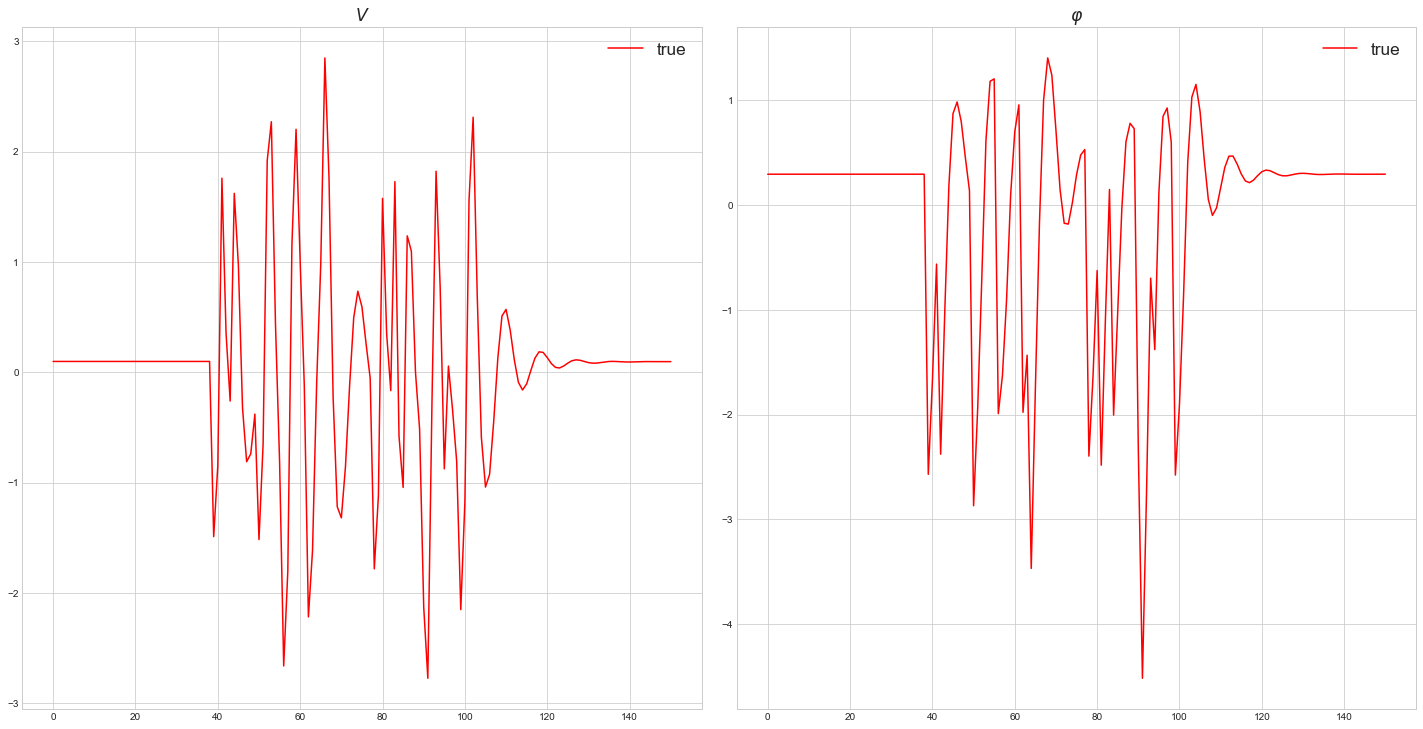

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
fig.tight_layout(h_pad=4.0)
for i, (ax, name) in enumerate(zip(axes.flatten(), var_names)):
    ax.plot(inputs[:, i], c='r', label='true')
    ax.set_title(name, fontsize='xx-large')
    ax.legend(loc='best', fontsize='xx-large')

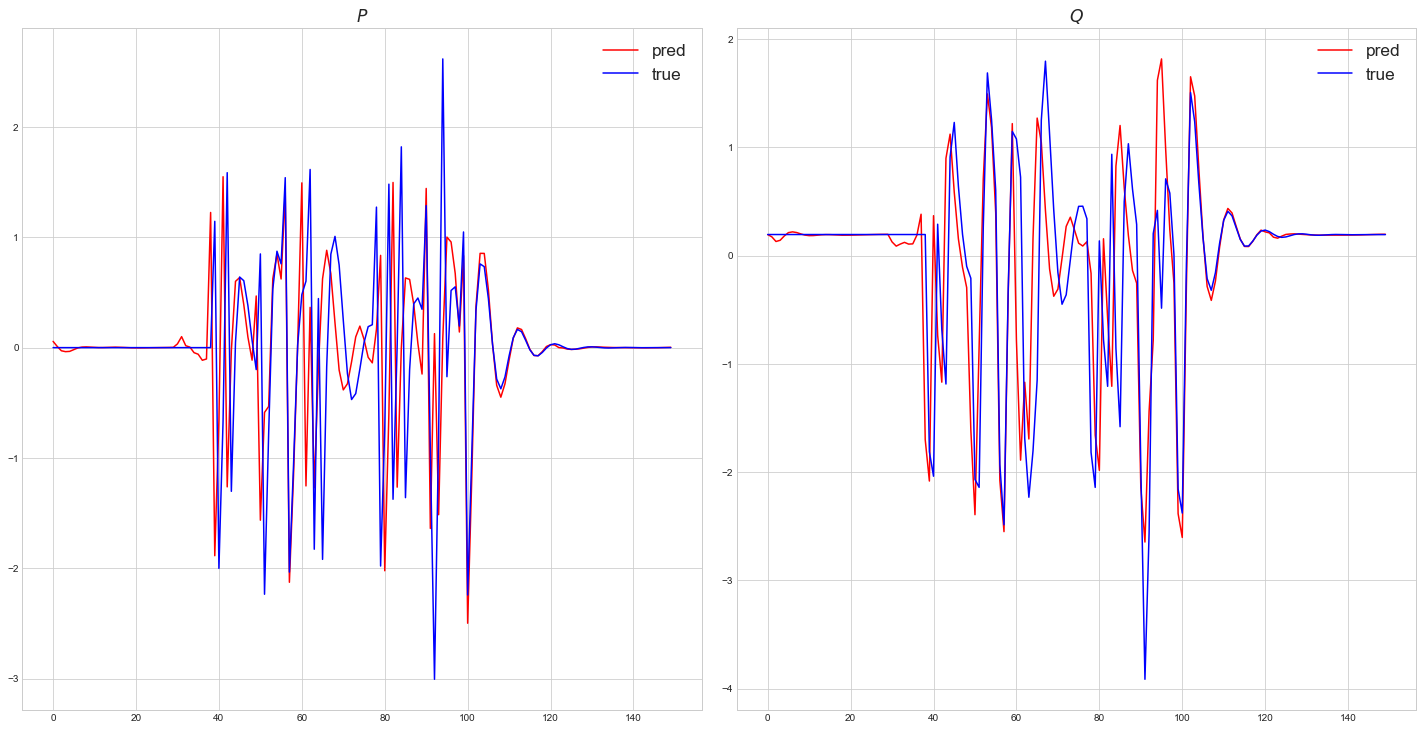

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
fig.tight_layout(h_pad=4.0)
for i, (ax, name) in enumerate(zip(axes.flatten(), var_names)):
    ax.plot(predicted[:, i], c='r', label='pred')
    ax.plot(outputs[:, i], c='b', label='true')
    ax.set_title(name, fontsize='xx-large')
    ax.legend(loc='best', fontsize='xx-large')

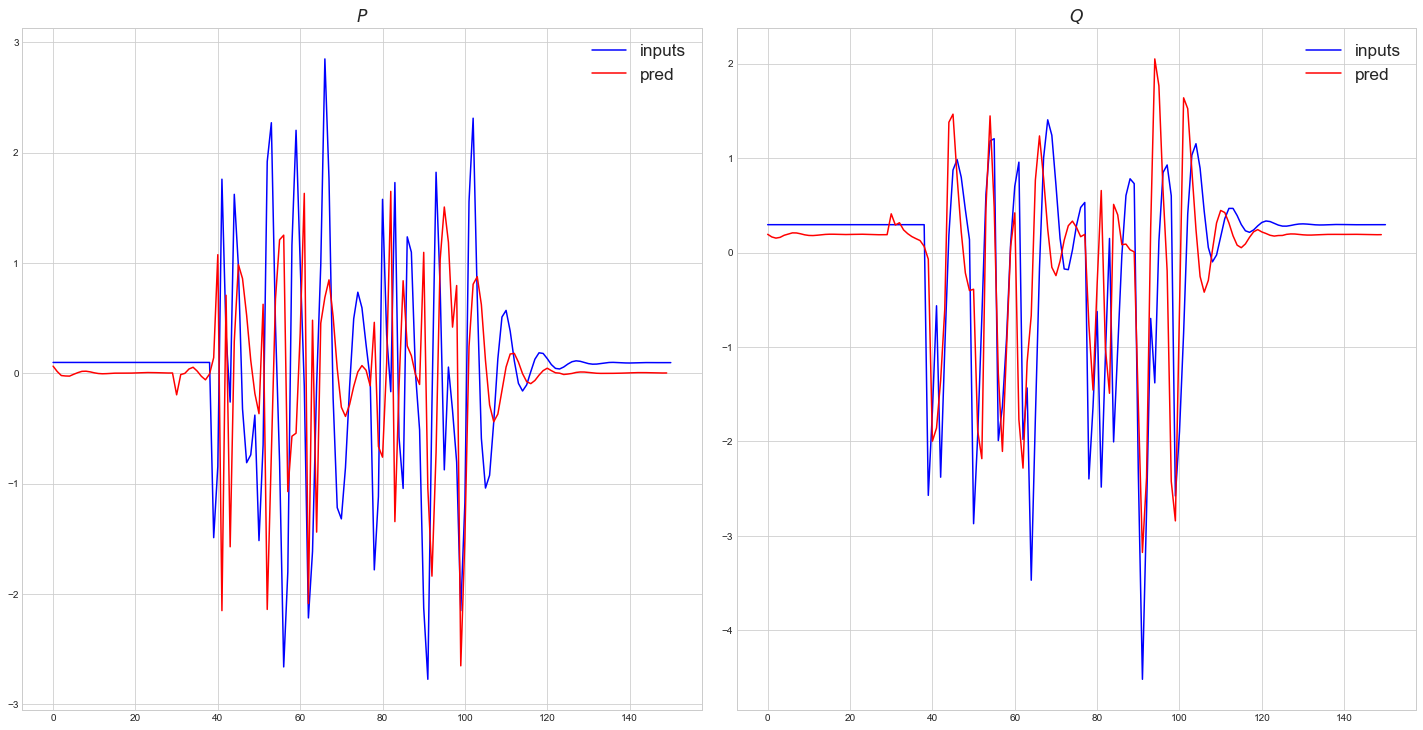

In [108]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
fig.tight_layout(h_pad=4.0)
for i, (ax, name) in enumerate(zip(axes.flatten(), var_names)):
    ax.plot(inputs[:, i], c='b', label='inputs')
    ax.plot(predicted[:, i], c='r', label='pred')
    ax.set_title(name, fontsize='xx-large')
    ax.legend(loc='best', fontsize='xx-large')

In [129]:
model.save_weights('model.h5')

In [130]:
encoder_model.save_weights('model_encoder.h5')

In [131]:
decoder_model.save_weights('model_decoder.h5')

In [132]:
files_valid = os.listdir('data_sparse_val')
n_files = len(files_valid)
errs = list()
for i in tnrange(batch_size, n_files // batch_size * batch_size + 1, batch_size, desc='data'):
    idx = range(i-batch_size, i)
    fnames = ['data_sparse_val/' + files_valid[i] for i in idx]
    vals = [pd.read_csv(fname).drop(['t'], axis=1).values for fname in fnames]
    true = [val[:, 2:] for val in vals]
    vals = [sc.transform(val) for val in vals]
    inputs = [val[:, :2] for val in vals]
    model.reset_states()
    predicted = np.zeros((batch_size, 151, 2))
    for j in range(horizon, 151 // horizon * horizon + 1, horizon):
        batch = np.zeros((batch_size, horizon, num_vars))
        for k in range(batch_size):
            batch[k] = inputs[k][j-horizon:j]
        states_value = encoder_model.predict_on_batch(batch)

        target_seq = np.zeros((batch_size, 1, num_vars))
        for k in range(batch_size):
            if j > horizon:
                target_seq[k] = predicted[k][j-horizon-1]
            else:
                target_seq[k] = inputs[k][-1]

        for _ in range(30):
            output_tokens, h, c = decoder_model.predict_on_batch([target_seq] + states_value)
            for k in range(batch_size):
                predicted[k][j-horizon:j] = output_tokens[k]
                target_seq[k] = output_tokens[k]
            states_value = [h, c]
            
    predicted = sc.inverse_transform(np.concatenate([inputs, predicted], axis=2))[:, :, 2:]
    
    err = [np.sqrt(np.mean(np.sum((t - p) ** 2, axis=1))) / np.sqrt(np.mean(np.sum(t ** 2, axis=1))) \
           for t, p in zip(true, predicted)]
    errs.extend(err)

HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

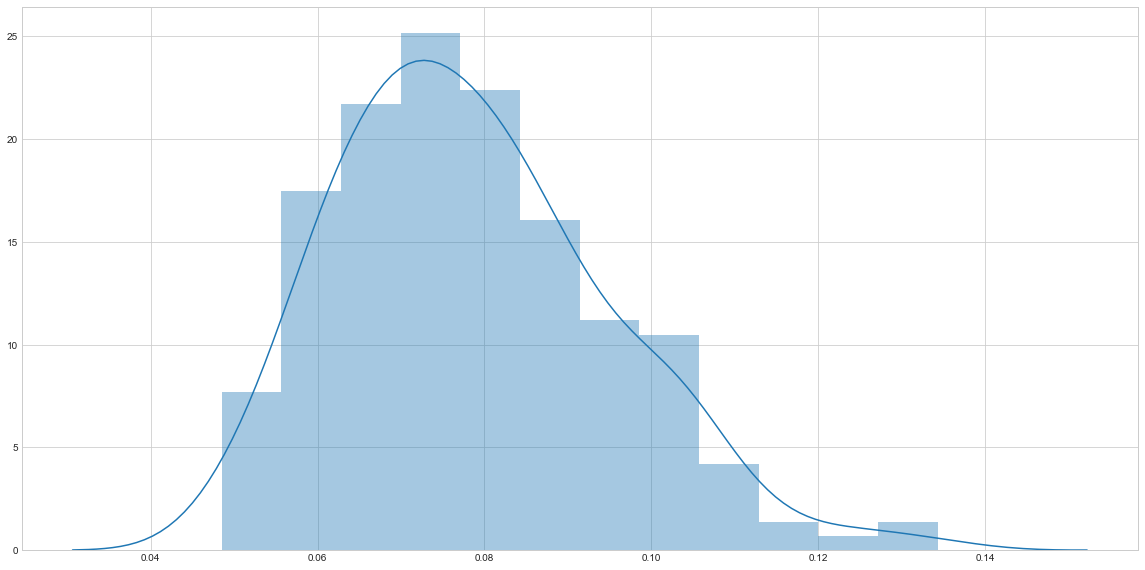

In [133]:
plt.figure(figsize=(20,10))
sns.distplot(errs)

In [134]:
print(len(np.where(np.array(errs) <= 0.05)[0]) / len(errs),
      np.percentile(errs, 95), np.mean(errs), np.median(errs))

0.015 0.10622419657650235 0.07855827380059434 0.07677386379334675


In [35]:
files_valid = os.listdir('data_sparse_test')
try:
    files_valid.pop(files_valid.index('.DS_Store'))
except ValueError as e:
    print(e)
n_files = len(files_valid)
errs = list()
for i in tnrange(batch_size, n_files // batch_size * batch_size + 1, batch_size, desc='data'):
    idx = range(i-batch_size, i)
    fnames = ['data_sparse_test/' + files_valid[i] for i in idx]
    vals = [pd.read_csv(fname).drop(['t'], axis=1).values for fname in fnames]
    true = [val[:, 2:] for val in vals]
    vals = [sc.transform(val) for val in vals]
    inputs = [val[:, :2] for val in vals]
    model.reset_states()
    predicted = np.zeros((batch_size, 151, 2))
    for j in range(horizon, len(vals[0]) // horizon * horizon + 1, horizon):
        batch = np.zeros((batch_size, horizon, num_vars))
        for k in range(batch_size):
            batch[k] = inputs[k][j-horizon:j]
        states_value = encoder_model.predict_on_batch(batch)

        target_seq = np.zeros((batch_size, 1, num_vars))
        for k in range(batch_size):
            if j > horizon:
                target_seq[k] = predicted[k][j-horizon-1]
            else:
                target_seq[k] = inputs[k][-1]

        for _ in range(50):
            output_tokens, h, c = decoder_model.predict_on_batch([target_seq] + states_value)
            for k in range(batch_size):
                predicted[k][j-horizon:j] = output_tokens[k]
                target_seq[k] = output_tokens[k]
            states_value = [h, c]
            
    predicted = sc.inverse_transform(np.concatenate([inputs, predicted], axis=2))[:, :, 2:]
    
    err = [np.sqrt(np.mean(np.sum((t - p) ** 2, axis=1))) / np.sqrt(np.mean(np.sum(t ** 2, axis=1))) \
           for t, p in zip(true, predicted)]
    errs.extend(err)

'.DS_Store' is not in list


HBox(children=(IntProgress(value=0, description='data', max=4), HTML(value='')))

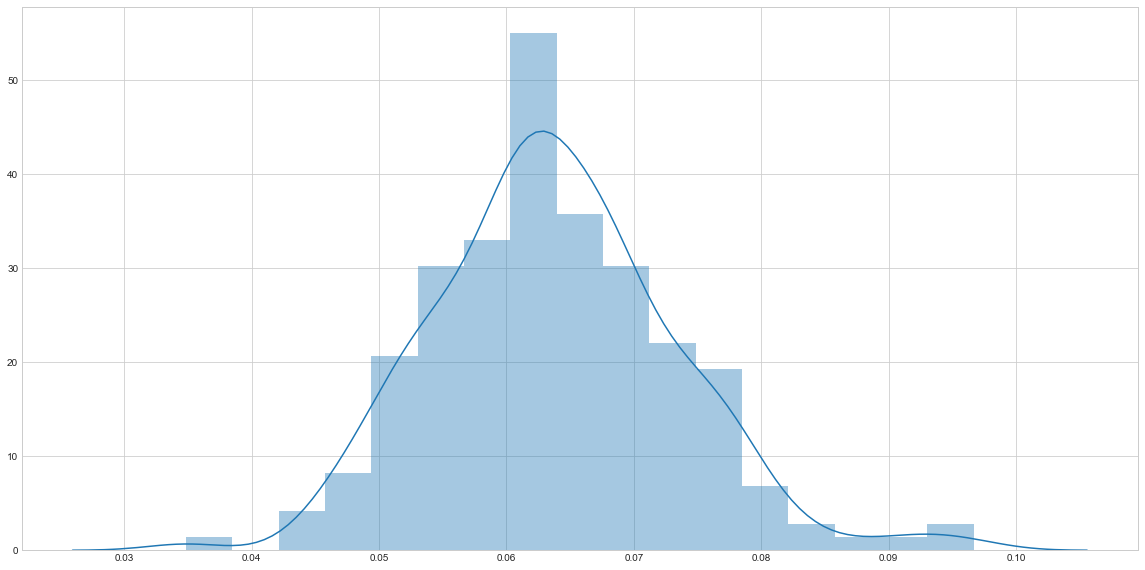

In [36]:
plt.figure(figsize=(20,10))
sns.distplot(errs)

In [137]:
print(len(np.where(np.array(errs) <= 0.05)[0]) / len(errs),
      np.percentile(errs, 95), np.mean(errs), np.median(errs))

0.06 0.0786701199955786 0.06376941305299652 0.06318019055337362


In [75]:
np.argmax(errs[150:])

46

In [74]:
len(errs)

200

In [76]:
files_valid[196]

'data_1787.csv'

In [77]:
errs[196]

0.07125558165209601

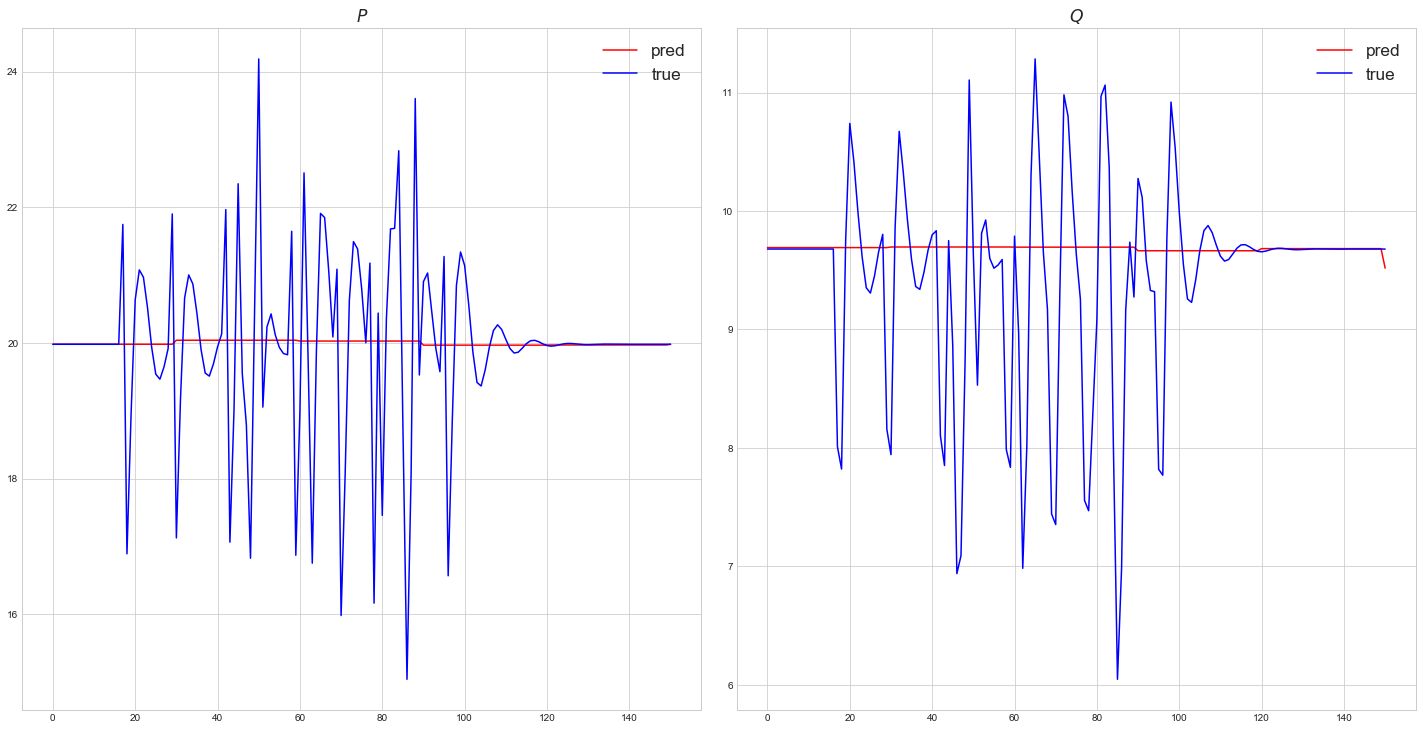

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
fig.tight_layout(h_pad=4.0)
for i, (ax, name) in enumerate(zip(axes.flatten(), var_names)):
    ax.plot(predicted[-4, :, i], c='r', label='pred')
    ax.plot(true[-4][:, i], c='b', label='true')
    ax.set_title(name, fontsize='xx-large')
    ax.legend(loc='best', fontsize='xx-large')

In [ ]:
files_valid = os.listdir('data_val')
n_files = len(files_valid)
errs_p = list()
errs_q = list()
for i in tnrange(batch_size, n_files // batch_size * batch_size + 1, batch_size, desc='data'):
    idx = range(i-batch_size, i)
    fnames = ['data_val/' + files_valid[i] for i in idx]
    vals = [pd.read_csv(fname).drop(['t'], axis=1).values for fname in fnames]
    true = [val[:150_000, 2:] for val in vals]
    vals = [sc.transform(val) for val in vals]
    inputs = [val[:, :2] for val in vals]
    model.reset_states()
    predicted = np.zeros((batch_size, 150000, 2))
    for k in range(horizon, 150_000, horizon):
        batch = np.zeros((batch_size, horizon, 2))
        for j in range(batch_size):
            batch[j] = inputs[j][k-horizon:k]
        preds = model.predict_on_batch(batch)
        for j in range(batch_size):
            predicted[j][k-horizon:k] = sc.inverse_transform(np.hstack([np.zeros((horizon, 2)), preds[j]]))[:, 2:]
    err_p = [np.sqrt(np.mean((t[:, 0] - p[:, 0]) ** 2)) / np.sqrt(np.mean(t[:, 0] ** 2)) \
             for t, p in zip(true, predicted)]
    err_q = [np.sqrt(np.mean((t[:, 1] - p[:, 1]) ** 2)) / np.sqrt(np.mean(t[:, 1] ** 2)) \
             for t, p in zip(true, predicted)]
    errs_p.extend(err_p)
    errs_q.extend(err_q)

In [ ]:
plt.figure(figsize=(20,20))
sns.distplot(errs_p)

In [ ]:
plt.figure(figsize=(20,20))
sns.distplot(errs_q)

In [ ]:
print(len(np.where(np.array(errs_p) <= 0.05)[0]) / len(errs_p) * 100,
      np.percentile(errs_p, 95), np.mean(errs_p), np.median(errs_p))

In [ ]:
print(len(np.where(np.array(errs_q) <= 0.05)[0]) / len(errs_q) * 100,
      np.percentile(errs_q, 95), np.mean(errs_q), np.median(errs_q))

In [ ]:
files_valid = os.listdir('data_test')
files_valid.pop(files_valid.index('.DS_Store'))
n_files = len(files_valid)
errs_test_p = list()
errs_test_q = list()
for i in tnrange(batch_size, n_files // batch_size * batch_size + 1, batch_size, desc='data'):
    idx = range(i-batch_size, i)
    fnames = ['data_test/' + files_valid[i] for i in idx]
    vals = [pd.read_csv(fname).drop(['t'], axis=1).values for fname in fnames]
    true = [val[:150_000, 2:] for val in vals]
    vals = [sc.transform(val) for val in vals]
    inputs = [val[:, :2] for val in vals]
    model.reset_states()
    predicted = np.zeros((batch_size, 150000, 2))
    for k in range(horizon, 150_000, horizon):
        batch = np.zeros((batch_size, horizon, 2))
        for j in range(batch_size):
            batch[j] = inputs[j][k-horizon:k]
        preds = model.predict_on_batch(batch)
        for j in range(batch_size):
            predicted[j][k-horizon:k] = sc.inverse_transform(np.hstack([np.zeros((horizon, 2)), preds[j]]))[:, 2:]
    err_p = [np.sqrt(np.mean((t[:, 0] - p[:, 0]) ** 2)) / np.sqrt(np.mean(t[:, 0] ** 2)) \
             for t, p in zip(true, predicted)]
    err_q = [np.sqrt(np.mean((t[:, 1] - p[:, 1]) ** 2)) / np.sqrt(np.mean(t[:, 1] ** 2)) \
             for t, p in zip(true, predicted)]
    errs_test_p.extend(err_p)
    errs_test_q.extend(err_q)

In [ ]:
plt.figure(figsize=(20,20))
sns.distplot(errs_test_p)

In [ ]:
plt.figure(figsize=(20,20))
sns.distplot(errs_test_q)

In [ ]:
print(len(np.where(np.array(errs_test_p) <= 0.05)[0]) / len(errs_test_p) * 100,
      np.percentile(errs_test_p, 95), np.mean(errs_test_p), np.median(errs_test_p))

In [ ]:
print(len(np.where(np.array(errs_test_q) <= 0.05)[0]) / len(errs_test_q) * 100,
      np.percentile(errs_test_q, 95), np.mean(errs_test_q), np.median(errs_test_q))

In [28]:
from keras.utils import plot_model

In [34]:
plot_model(model, 'model_lstm.png')

['dot', '-Tpng', '/var/folders/gy/_c84k2mn2nv0k4wz6vr6yxq40000gn/T/tmpatk6hal7'] return code: -11

stdout, stderr:
 b''
b'Error: in routesplines, cannot find NORMAL edge\n'



AssertionError: -11